# Time Series - TensorFlow
Regional with no series manipulation

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from pathlib import Path

import os, sys
sys.path.insert(0, os.path.abspath('../src'))

from ts import *
from utils import *
from tfts import *

import tensorflow as tf

In [2]:
data_path = "../data"

In [3]:
DataDownloader(data_path).download_all_csv()

In [4]:
covidpro_df, dpc_regioni_df, _, _, _ = load_data(data_path)

In [5]:
province = "Lombardia"
compart = "nuovi_positivi"
date = 'data'

In [6]:
df = dpc_regioni_df[dpc_regioni_df.denominazione_regione == province].query('20200701 > data')

In [7]:
df = df.set_index(date)

In [8]:
df_multi = df.loc[:, ['ricoverati_con_sintomi', 'terapia_intensiva', 'totale_ospedalizzati',
       'isolamento_domiciliare', 'totale_positivi', 'nuovi_positivi', 'dimessi_guariti',
       'deceduti', 'tamponi']]
df = df.loc[:, [compart]]

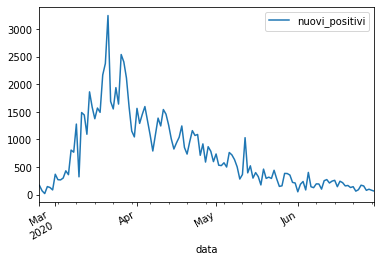

In [9]:
df.plot(subplots=True)
plt.show()

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
nuovi_positivi,128.0,733.554688,645.463684,18.0,214.5,501.0,1109.75,3251.0


In [11]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.4)]
val_df = df[int(n*0.4):int(n*0.7)]
test_df = df[int(n*0.7):]

num_features = df.shape[1]

In [12]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

## Single step

In [13]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=[compart])
    
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['nuovi_positivi']

In [14]:
baseline = Baseline(label_index=column_indices[compart])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError(), 
                          tf.metrics.MeanSquaredError()])

val_performance = {}
performance = {}

In [15]:
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)

2/2 [==============================] - 0s 1ms/step - loss: 0.1032 - mean_absolute_error: 0.2484 - mean_squared_error: 0.1032


In [16]:
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

### Wide window

In [17]:
wide_window = WindowGenerator(
    input_width=14, label_width=14, shift=14,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=[compart])

wide_window

Total window size: 28
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [14 15 16 17 18 19 20 21 22 23 24 25 26 27]
Label column name(s): ['nuovi_positivi']

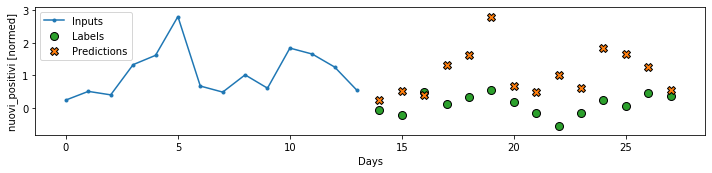

In [18]:
wide_window.plot(baseline, plot_col=compart)

In [19]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [20]:
history = compile_and_fit(linear, single_step_window)

======================] - 0s 52ms/step - loss: 0.4706 - mean_absolute_error: 0.5321 - mean_squared_error: 0.4706 - val_loss: 0.2963 - val_mean_absolute_error: 0.4737 - val_mean_squared_error: 0.2963
Epoch 13/100
2/2 [==============================] - 0s 45ms/step - loss: 0.4690 - mean_absolute_error: 0.5312 - mean_squared_error: 0.4690 - val_loss: 0.2956 - val_mean_absolute_error: 0.4731 - val_mean_squared_error: 0.2956
Epoch 14/100
2/2 [==============================] - 0s 49ms/step - loss: 0.4677 - mean_absolute_error: 0.5305 - mean_squared_error: 0.4677 - val_loss: 0.2947 - val_mean_absolute_error: 0.4724 - val_mean_squared_error: 0.2947
Epoch 15/100
2/2 [==============================] - 0s 37ms/step - loss: 0.4664 - mean_absolute_error: 0.5297 - mean_squared_error: 0.4664 - val_loss: 0.2940 - val_mean_absolute_error: 0.4718 - val_mean_squared_error: 0.2940
Epoch 16/100
2/2 [==============================] - 0s 37ms/step - loss: 0.4648 - mean_absolute_error: 0.5290 - mean_squared_e

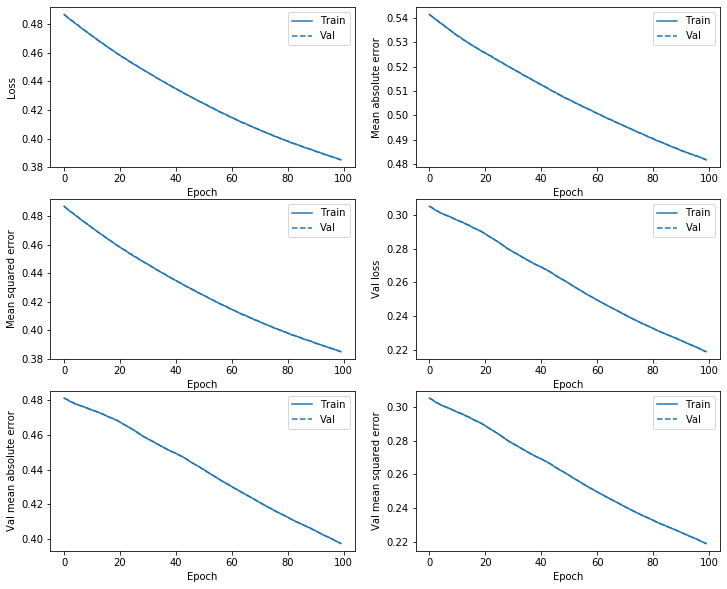

In [21]:
plot_metrics(history)

In [22]:
val_performance['Linear'] = linear.evaluate(single_step_window.val)

2/2 [==============================] - 0s 1ms/step - loss: 0.2189 - mean_absolute_error: 0.3976 - mean_squared_error: 0.2189


In [23]:
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

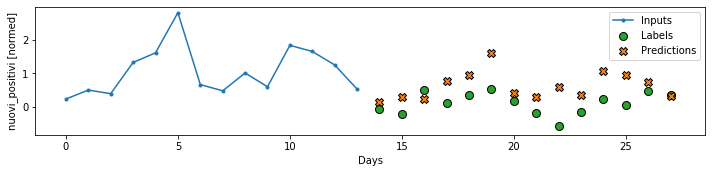

In [24]:
wide_window.plot(linear, plot_col=compart)

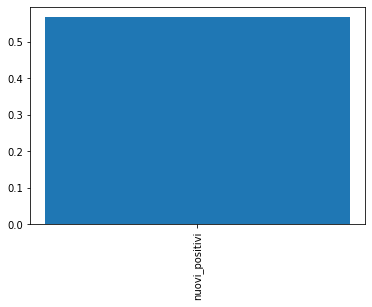

In [25]:
# Show weights
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
axis.set_xticklabels(train_df.columns, rotation=90)
plt.show()

In [26]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

Epoch 1/100
2/2 [==============================] - 0s 116ms/step - loss: 1.0311 - mean_absolute_error: 0.8076 - mean_squared_error: 1.0311 - val_loss: 0.6502 - val_mean_absolute_error: 0.7166 - val_mean_squared_error: 0.6502
Epoch 2/100
2/2 [==============================] - 0s 57ms/step - loss: 0.9370 - mean_absolute_error: 0.7662 - mean_squared_error: 0.9370 - val_loss: 0.5859 - val_mean_absolute_error: 0.6775 - val_mean_squared_error: 0.5859
Epoch 3/100
2/2 [==============================] - 0s 39ms/step - loss: 0.8398 - mean_absolute_error: 0.7241 - mean_squared_error: 0.8398 - val_loss: 0.5310 - val_mean_absolute_error: 0.6422 - val_mean_squared_error: 0.5310
Epoch 4/100
2/2 [==============================] - 0s 43ms/step - loss: 0.7691 - mean_absolute_error: 0.6875 - mean_squared_error: 0.7691 - val_loss: 0.4801 - val_mean_absolute_error: 0.6080 - val_mean_squared_error: 0.4801
Epoch 5/100
2/2 [==============================] - 0s 39ms/step - loss: 0.7036 - mean_absolute_error: 0

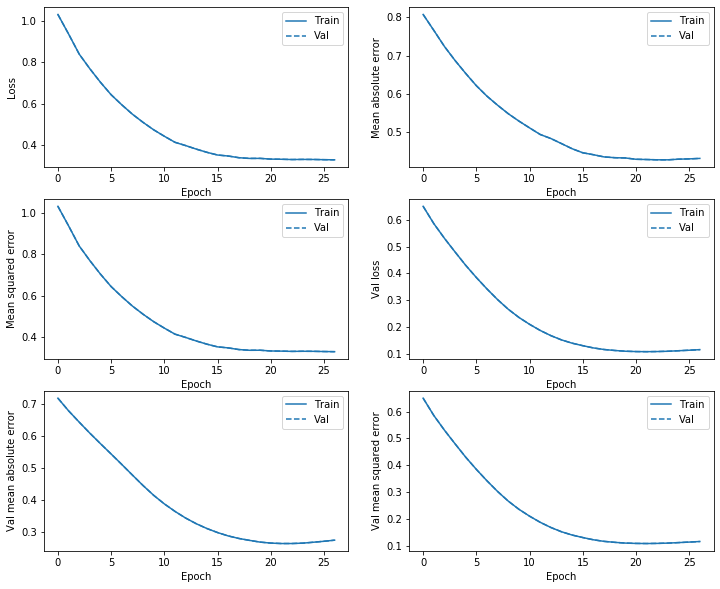

In [27]:
plot_metrics(history)

In [28]:
val_performance['Dense'] = dense.evaluate(single_step_window.val)

2/2 [==============================] - 0s 1ms/step - loss: 0.1160 - mean_absolute_error: 0.2755 - mean_squared_error: 0.1160


In [29]:
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

In [30]:
CONV_WIDTH = 14
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=[compart])

conv_window

Total window size: 15
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [14]
Label column name(s): ['nuovi_positivi']

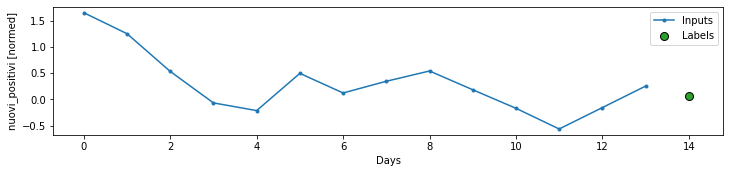

In [31]:
conv_window.plot(plot_col=compart)

In [32]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [33]:
history = compile_and_fit(multi_step_dense, conv_window)

Epoch 1/100
2/2 [==============================] - 0s 98ms/step - loss: 1.3892 - mean_absolute_error: 0.9939 - mean_squared_error: 1.3892 - val_loss: 0.1111 - val_mean_absolute_error: 0.2854 - val_mean_squared_error: 0.1111
Epoch 2/100
2/2 [==============================] - 0s 40ms/step - loss: 1.2060 - mean_absolute_error: 0.9043 - mean_squared_error: 1.2060 - val_loss: 0.1695 - val_mean_absolute_error: 0.3637 - val_mean_squared_error: 0.1695
Epoch 3/100
2/2 [==============================] - 0s 35ms/step - loss: 1.0528 - mean_absolute_error: 0.8260 - mean_squared_error: 1.0528 - val_loss: 0.2501 - val_mean_absolute_error: 0.4540 - val_mean_squared_error: 0.2501
Epoch 4/100
2/2 [==============================] - 0s 41ms/step - loss: 0.9286 - mean_absolute_error: 0.7580 - mean_squared_error: 0.9286 - val_loss: 0.3418 - val_mean_absolute_error: 0.5362 - val_mean_squared_error: 0.3418
Epoch 5/100
2/2 [==============================] - 0s 38ms/step - loss: 0.8255 - mean_absolute_error: 0.

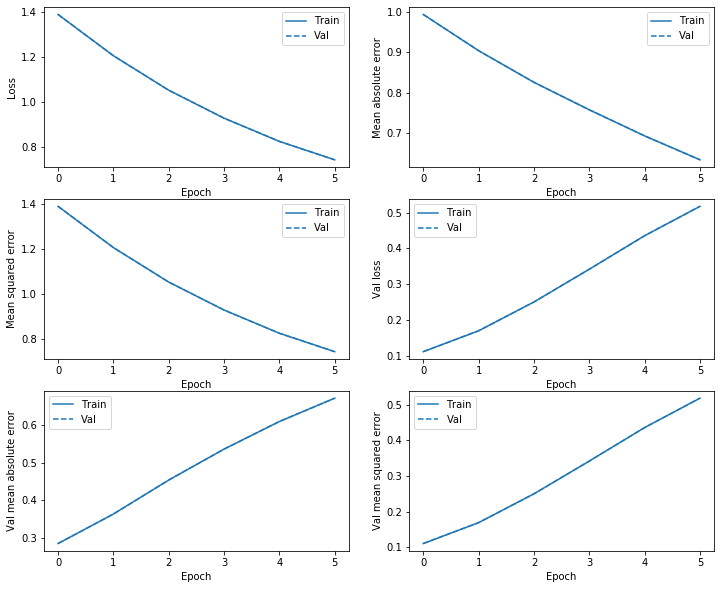

In [34]:
plot_metrics(history)

In [35]:
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)

1/1 [==============================] - 0s 2ms/step - loss: 0.5178 - mean_absolute_error: 0.6715 - mean_squared_error: 0.5178


In [36]:
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

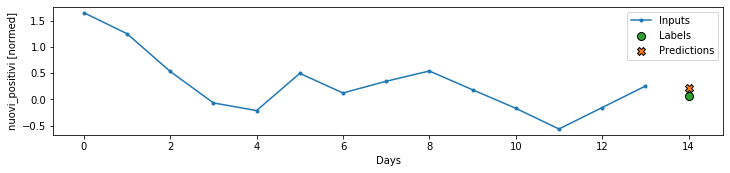

In [37]:
conv_window.plot(multi_step_dense, plot_col=compart)

In [38]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [39]:
history = compile_and_fit(lstm_model, wide_window)

Epoch 1/100
1/1 [==============================] - 1s 592ms/step - loss: 0.9752 - mean_absolute_error: 0.7330 - mean_squared_error: 0.9752 - val_loss: 0.9648 - val_mean_absolute_error: 0.9395 - val_mean_squared_error: 0.9648
Epoch 2/100
1/1 [==============================] - 0s 84ms/step - loss: 0.9497 - mean_absolute_error: 0.7224 - mean_squared_error: 0.9497 - val_loss: 0.9950 - val_mean_absolute_error: 0.9544 - val_mean_squared_error: 0.9950
Epoch 3/100
1/1 [==============================] - 0s 82ms/step - loss: 0.9253 - mean_absolute_error: 0.7119 - mean_squared_error: 0.9253 - val_loss: 1.0254 - val_mean_absolute_error: 0.9691 - val_mean_squared_error: 1.0254
Epoch 4/100
1/1 [==============================] - 0s 95ms/step - loss: 0.9020 - mean_absolute_error: 0.7015 - mean_squared_error: 0.9020 - val_loss: 1.0560 - val_mean_absolute_error: 0.9837 - val_mean_squared_error: 1.0560
Epoch 5/100
1/1 [==============================] - 0s 96ms/step - loss: 0.8796 - mean_absolute_error: 0

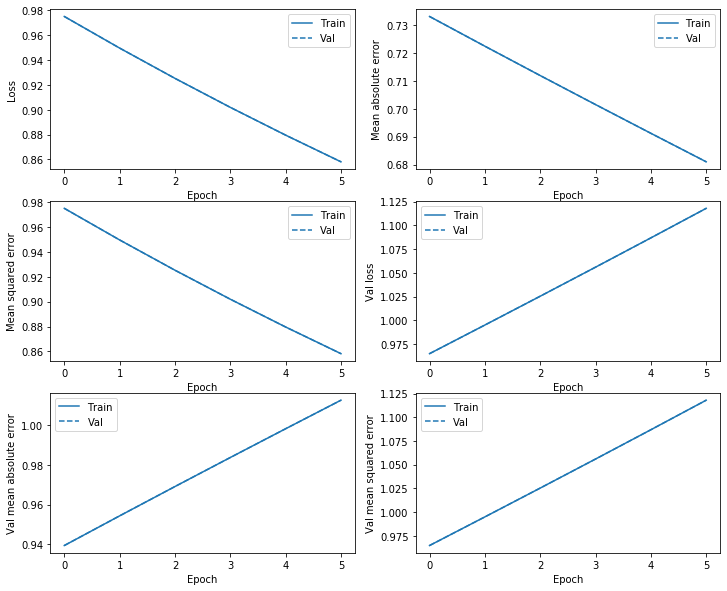

In [40]:
plot_metrics(history)

In [41]:
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 1.1181 - mean_absolute_error: 1.0125 - mean_squared_error: 1.1181


In [42]:
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

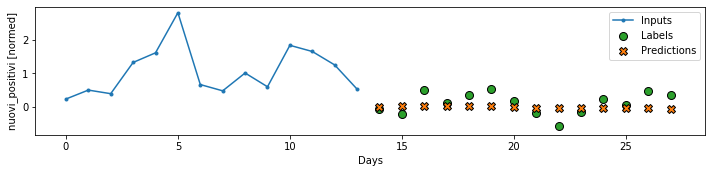

In [43]:
wide_window.plot(lstm_model, plot_col=compart)

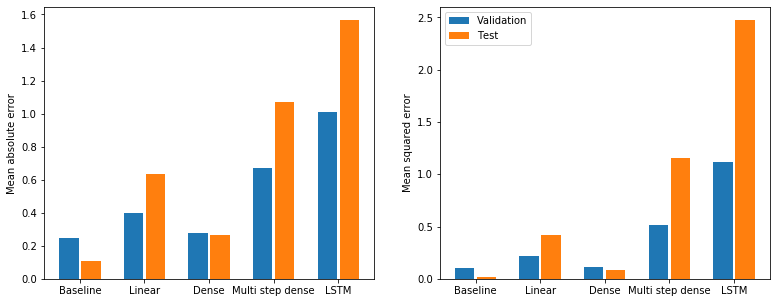

In [44]:
plot_comparison_results(lstm_model.metrics_names, val_performance, performance, figsize=(13,5))

### Multi-output

In [45]:
df = df_multi.copy()

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.4)]
val_df = df[int(n*0.4):int(n*0.7)]
test_df = df[int(n*0.7):]

num_features = df.shape[1]

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [46]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df)

wide_window = WindowGenerator(
    input_width=14, label_width=14, shift=14,
    train_df=train_df, val_df=val_df, test_df=test_df)

In [47]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError(),
                          tf.metrics.MeanSquaredError()])

In [48]:
val_performance = {}
performance = {}

val_performance['Baseline'] = baseline.evaluate(wide_window.val)

1/1 [==============================] - 0s 7ms/step - loss: 1.2800 - mean_absolute_error: 0.8843 - mean_squared_error: 1.2800


In [49]:
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

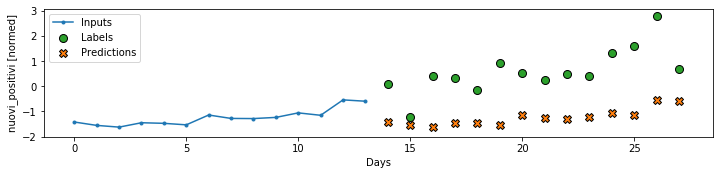

In [50]:
wide_window.plot(baseline, plot_col=compart)

In [51]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [52]:
history = compile_and_fit(dense, single_step_window)

Epoch 1/100
2/2 [==============================] - 0s 115ms/step - loss: 0.9419 - mean_absolute_error: 0.8564 - mean_squared_error: 0.9419 - val_loss: 6.8434 - val_mean_absolute_error: 1.8470 - val_mean_squared_error: 6.8434
Epoch 2/100
2/2 [==============================] - 0s 34ms/step - loss: 0.8482 - mean_absolute_error: 0.8139 - mean_squared_error: 0.8482 - val_loss: 5.9508 - val_mean_absolute_error: 1.7107 - val_mean_squared_error: 5.9508
Epoch 3/100
2/2 [==============================] - 0s 26ms/step - loss: 0.7678 - mean_absolute_error: 0.7735 - mean_squared_error: 0.7678 - val_loss: 5.1636 - val_mean_absolute_error: 1.5824 - val_mean_squared_error: 5.1636
Epoch 4/100
2/2 [==============================] - 0s 27ms/step - loss: 0.6869 - mean_absolute_error: 0.7297 - mean_squared_error: 0.6869 - val_loss: 4.5104 - val_mean_absolute_error: 1.4682 - val_mean_squared_error: 4.5104
Epoch 5/100
2/2 [==============================] - 0s 27ms/step - loss: 0.6174 - mean_absolute_error: 0

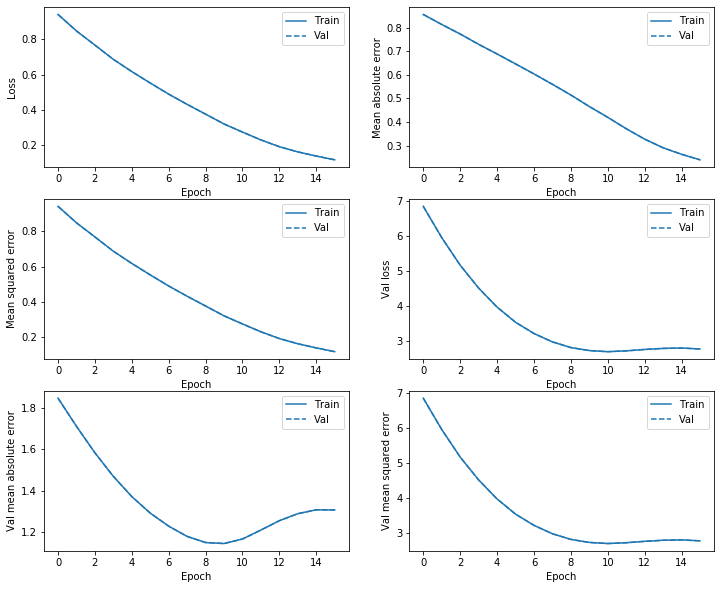

In [53]:
plot_metrics(history)

In [54]:
val_performance['Dense'] = dense.evaluate(single_step_window.val)

2/2 [==============================] - 0s 1ms/step - loss: 2.7724 - mean_absolute_error: 1.3058 - mean_squared_error: 2.7724


In [55]:
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

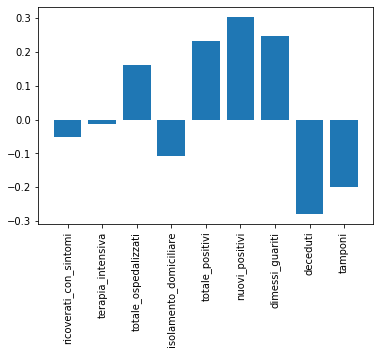

In [56]:
# Show weights
plt.bar(x = range(len(train_df.columns)),
        height=dense.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
axis.set_xticklabels(train_df.columns, rotation=90)
plt.show()

In [57]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

Epoch 1/100
1/1 [==============================] - 0s 495ms/step - loss: 0.5646 - mean_absolute_error: 0.6309 - mean_squared_error: 0.5646 - val_loss: 9.5065 - val_mean_absolute_error: 2.3354 - val_mean_squared_error: 9.5065
Epoch 2/100
1/1 [==============================] - 0s 51ms/step - loss: 0.5441 - mean_absolute_error: 0.6178 - mean_squared_error: 0.5441 - val_loss: 9.5111 - val_mean_absolute_error: 2.3296 - val_mean_squared_error: 9.5111
Epoch 3/100
1/1 [==============================] - 0s 61ms/step - loss: 0.5241 - mean_absolute_error: 0.6047 - mean_squared_error: 0.5241 - val_loss: 9.5166 - val_mean_absolute_error: 2.3238 - val_mean_squared_error: 9.5166
Epoch 4/100
1/1 [==============================] - 0s 58ms/step - loss: 0.5048 - mean_absolute_error: 0.5916 - mean_squared_error: 0.5048 - val_loss: 9.5227 - val_mean_absolute_error: 2.3182 - val_mean_squared_error: 9.5227
Epoch 5/100
1/1 [==============================] - 0s 62ms/step - loss: 0.4862 - mean_absolute_error: 0

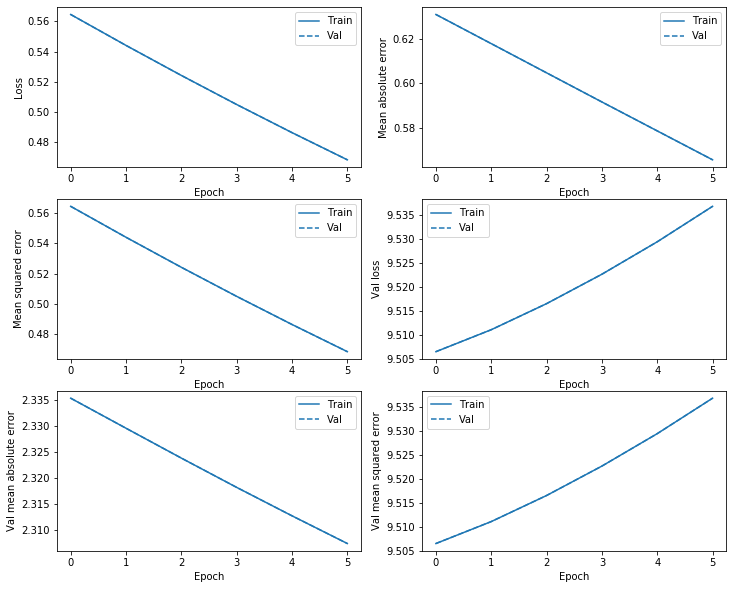

In [58]:
plot_metrics(history)

In [59]:
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 9.5369 - mean_absolute_error: 2.3074 - mean_squared_error: 9.5369


In [60]:
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

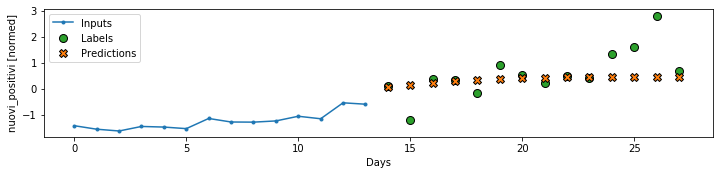

In [61]:
wide_window.plot(lstm_model, plot_col=compart)

In [62]:
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, wide_window)

Epoch 1/100
1/1 [==============================] - 1s 604ms/step - loss: 1.3162 - mean_absolute_error: 1.0518 - mean_squared_error: 1.3162 - val_loss: 1.2829 - val_mean_absolute_error: 0.8839 - val_mean_squared_error: 1.2829
Epoch 2/100
1/1 [==============================] - 0s 68ms/step - loss: 1.3067 - mean_absolute_error: 1.0477 - mean_squared_error: 1.3067 - val_loss: 1.2859 - val_mean_absolute_error: 0.8834 - val_mean_squared_error: 1.2859
Epoch 3/100
1/1 [==============================] - 0s 73ms/step - loss: 1.2968 - mean_absolute_error: 1.0435 - mean_squared_error: 1.2968 - val_loss: 1.2885 - val_mean_absolute_error: 0.8828 - val_mean_squared_error: 1.2885
Epoch 4/100
1/1 [==============================] - 0s 66ms/step - loss: 1.2861 - mean_absolute_error: 1.0388 - mean_squared_error: 1.2861 - val_loss: 1.2911 - val_mean_absolute_error: 0.8820 - val_mean_squared_error: 1.2911
Epoch 5/100
1/1 [==============================] - 0s 63ms/step - loss: 1.2746 - mean_absolute_error: 1

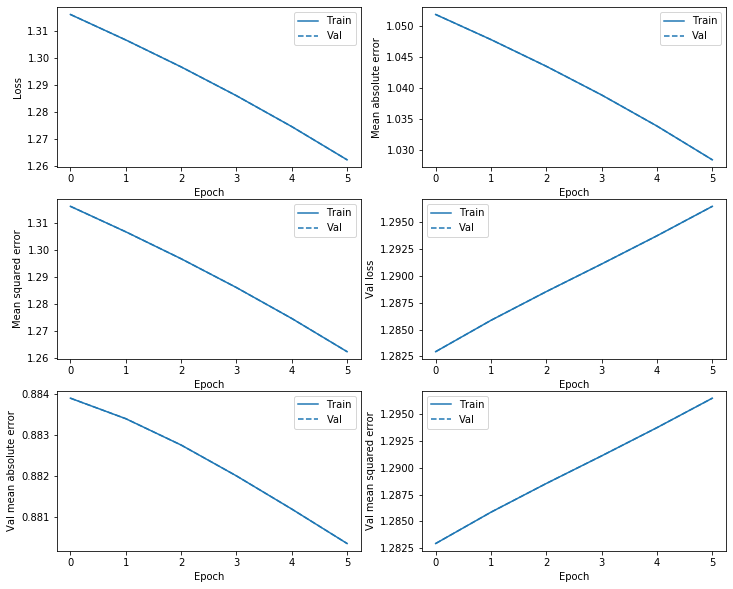

In [63]:
plot_metrics(history)

In [64]:
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)

1/1 [==============================] - 0s 2ms/step - loss: 1.2965 - mean_absolute_error: 0.8804 - mean_squared_error: 1.2965


In [65]:
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)

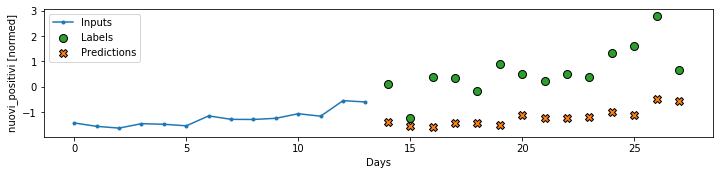

In [66]:
wide_window.plot(residual_lstm, plot_col=compart)

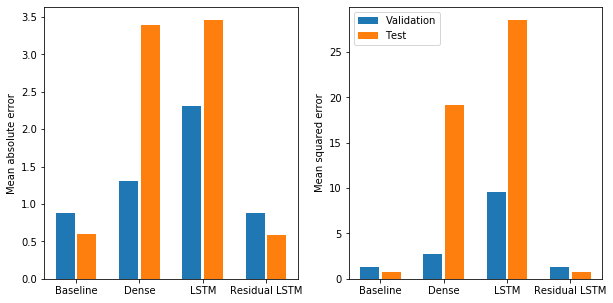

In [67]:
plot_comparison_results(lstm_model.metrics_names, val_performance, performance)

## Multi-step

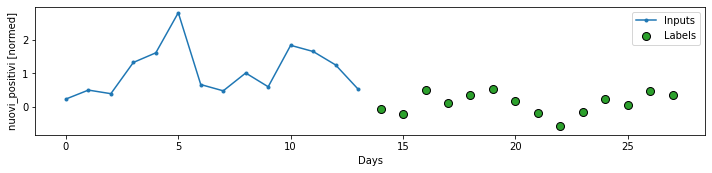

In [68]:
OUT_STEPS = 14
multi_window = WindowGenerator(
    input_width=14,
    label_width=OUT_STEPS,
    shift=OUT_STEPS,
    train_df=train_df, val_df=val_df, test_df=test_df)

multi_window.plot(plot_col=compart)

In [69]:
last_baseline = MultiStepLastBaseline(OUT_STEPS)
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError(),
                          tf.metrics.MeanSquaredError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val, verbose=0)

In [70]:
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)

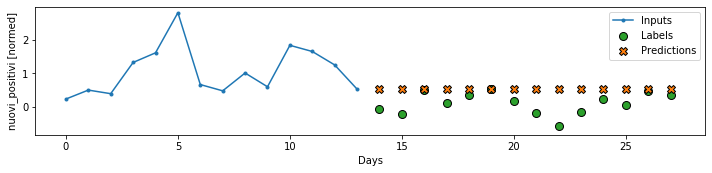

In [71]:
multi_window.plot(last_baseline, plot_col=compart)

In [72]:
repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError(),
                          tf.metrics.MeanSquaredError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val, verbose=0)

In [73]:
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)

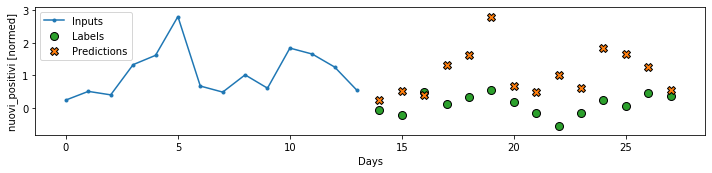

In [74]:
multi_window.plot(repeat_baseline, plot_col=compart)

### Single shot

In [75]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

===================] - 0s 75ms/step - loss: 0.5983 - mean_absolute_error: 0.6524 - mean_squared_error: 0.5983 - val_loss: 8.6198 - val_mean_absolute_error: 2.1914 - val_mean_squared_error: 8.6198
Epoch 13/100
1/1 [==============================] - 0s 75ms/step - loss: 0.5924 - mean_absolute_error: 0.6490 - mean_squared_error: 0.5924 - val_loss: 8.5637 - val_mean_absolute_error: 2.1829 - val_mean_squared_error: 8.5637
Epoch 14/100
1/1 [==============================] - 0s 96ms/step - loss: 0.5866 - mean_absolute_error: 0.6457 - mean_squared_error: 0.5866 - val_loss: 8.5083 - val_mean_absolute_error: 2.1744 - val_mean_squared_error: 8.5083
Epoch 15/100
1/1 [==============================] - 0s 93ms/step - loss: 0.5808 - mean_absolute_error: 0.6423 - mean_squared_error: 0.5808 - val_loss: 8.4535 - val_mean_absolute_error: 2.1661 - val_mean_squared_error: 8.4535
Epoch 16/100
1/1 [==============================] - 0s 77ms/step - loss: 0.5751 - mean_absolute_error: 0.6390 - mean_squared_erro

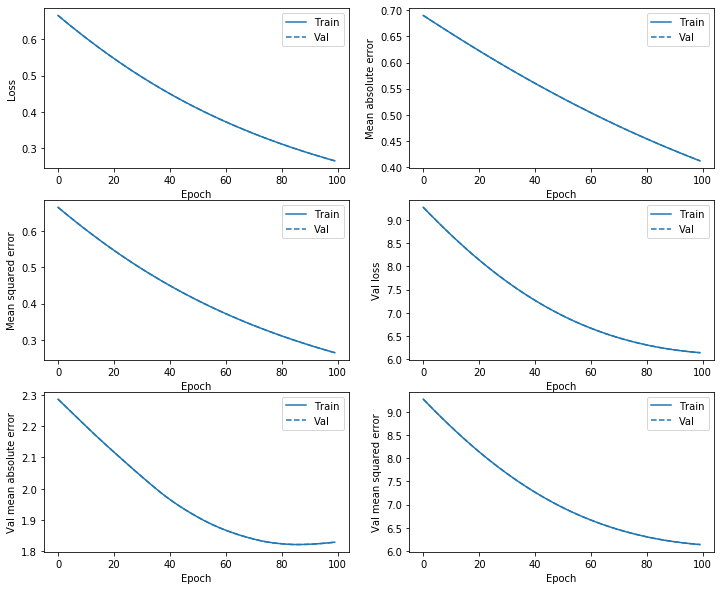

In [76]:
plot_metrics(history)

In [77]:
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)

1/1 [==============================] - 0s 944us/step - loss: 6.1387 - mean_absolute_error: 1.8290 - mean_squared_error: 6.1387


In [78]:
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)

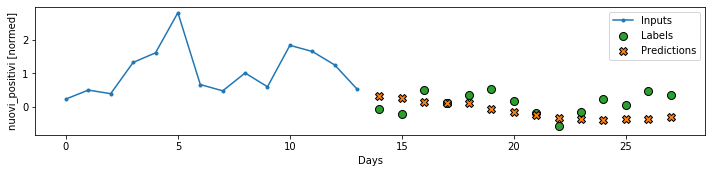

In [79]:
multi_window.plot(multi_linear_model, plot_col=compart)

In [80]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

Epoch 1/100
1/1 [==============================] - 0s 181ms/step - loss: 0.6663 - mean_absolute_error: 0.6902 - mean_squared_error: 0.6663 - val_loss: 9.1262 - val_mean_absolute_error: 2.2916 - val_mean_squared_error: 9.1262
Epoch 2/100
1/1 [==============================] - 0s 64ms/step - loss: 0.6335 - mean_absolute_error: 0.6704 - mean_squared_error: 0.6335 - val_loss: 8.9104 - val_mean_absolute_error: 2.2871 - val_mean_squared_error: 8.9104
Epoch 3/100
1/1 [==============================] - 0s 58ms/step - loss: 0.5996 - mean_absolute_error: 0.6494 - mean_squared_error: 0.5996 - val_loss: 8.6868 - val_mean_absolute_error: 2.2809 - val_mean_squared_error: 8.6868
Epoch 4/100
1/1 [==============================] - 0s 64ms/step - loss: 0.5645 - mean_absolute_error: 0.6273 - mean_squared_error: 0.5645 - val_loss: 8.4554 - val_mean_absolute_error: 2.2727 - val_mean_squared_error: 8.4554
Epoch 5/100
1/1 [==============================] - 0s 55ms/step - loss: 0.5283 - mean_absolute_error: 0

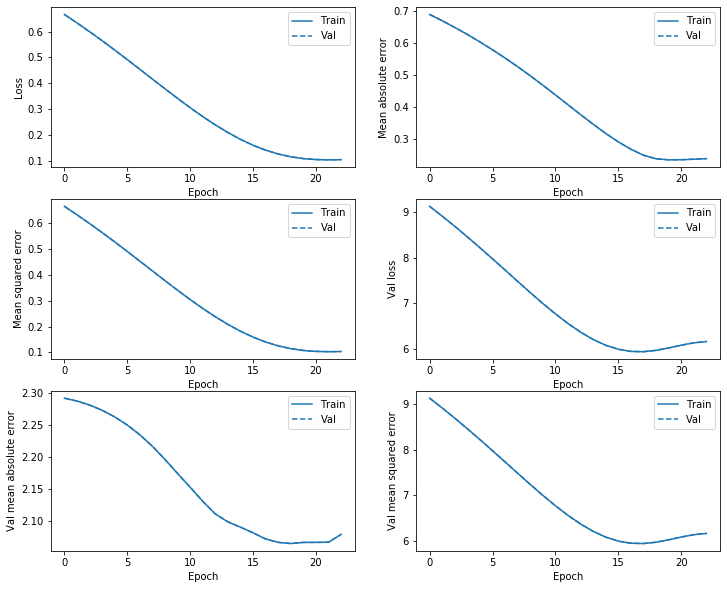

In [81]:
plot_metrics(history)

In [82]:
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 6.1597 - mean_absolute_error: 2.0789 - mean_squared_error: 6.1597


In [83]:
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)

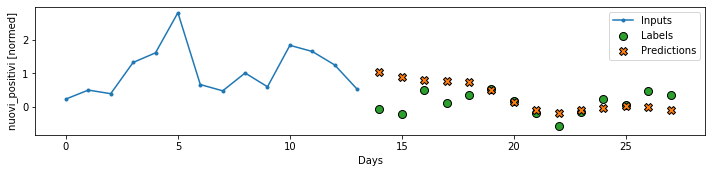

In [84]:
multi_window.plot(multi_dense_model, plot_col=compart)

In [85]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

Epoch 1/100
1/1 [==============================] - 0s 366ms/step - loss: 0.6663 - mean_absolute_error: 0.6902 - mean_squared_error: 0.6663 - val_loss: 9.3348 - val_mean_absolute_error: 2.2936 - val_mean_squared_error: 9.3348
Epoch 2/100
1/1 [==============================] - 0s 43ms/step - loss: 0.6589 - mean_absolute_error: 0.6860 - mean_squared_error: 0.6589 - val_loss: 9.3326 - val_mean_absolute_error: 2.2924 - val_mean_squared_error: 9.3326
Epoch 3/100
1/1 [==============================] - 0s 53ms/step - loss: 0.6511 - mean_absolute_error: 0.6817 - mean_squared_error: 0.6511 - val_loss: 9.3305 - val_mean_absolute_error: 2.2911 - val_mean_squared_error: 9.3305
Epoch 4/100
1/1 [==============================] - 0s 56ms/step - loss: 0.6429 - mean_absolute_error: 0.6772 - mean_squared_error: 0.6429 - val_loss: 9.3284 - val_mean_absolute_error: 2.2899 - val_mean_squared_error: 9.3284
Epoch 5/100
1/1 [==============================] - 0s 66ms/step - loss: 0.6344 - mean_absolute_error: 0

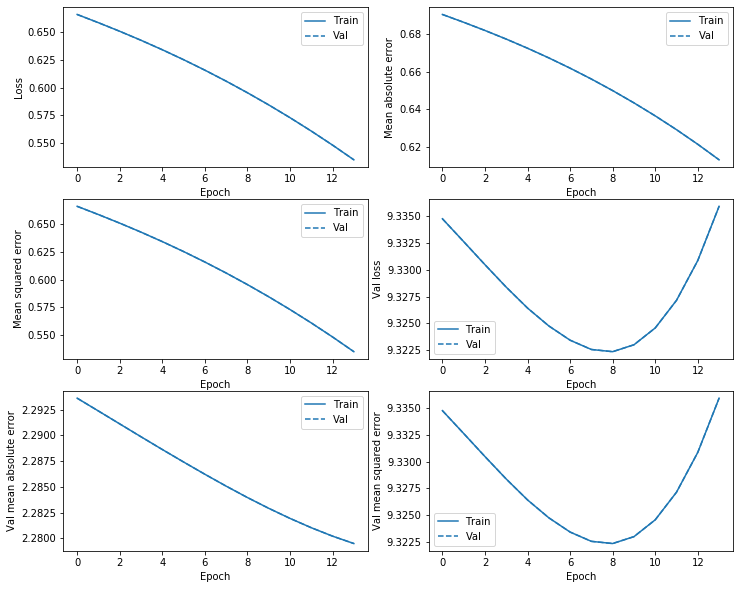

In [86]:
plot_metrics(history)

In [87]:
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 9.3359 - mean_absolute_error: 2.2795 - mean_squared_error: 9.3359


In [88]:
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)

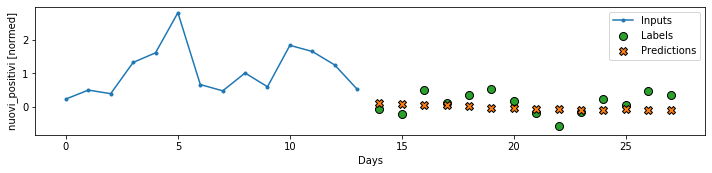

In [89]:
multi_window.plot(multi_lstm_model, plot_col=compart)

## AR model

In [90]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS, num_features=num_features)

In [91]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([24, 9])

In [92]:
history = compile_and_fit(feedback_model, multi_window)

Epoch 1/100
1/1 [==============================] - 1s 527ms/step - loss: 0.6581 - mean_absolute_error: 0.6793 - mean_squared_error: 0.6581 - val_loss: 8.9919 - val_mean_absolute_error: 2.2794 - val_mean_squared_error: 8.9919
Epoch 2/100
1/1 [==============================] - 0s 71ms/step - loss: 0.6422 - mean_absolute_error: 0.6701 - mean_squared_error: 0.6422 - val_loss: 8.9442 - val_mean_absolute_error: 2.2753 - val_mean_squared_error: 8.9442
Epoch 3/100
1/1 [==============================] - 0s 60ms/step - loss: 0.6269 - mean_absolute_error: 0.6610 - mean_squared_error: 0.6269 - val_loss: 8.8950 - val_mean_absolute_error: 2.2707 - val_mean_squared_error: 8.8950
Epoch 4/100
1/1 [==============================] - 0s 68ms/step - loss: 0.6121 - mean_absolute_error: 0.6518 - mean_squared_error: 0.6121 - val_loss: 8.8441 - val_mean_absolute_error: 2.2659 - val_mean_squared_error: 8.8441
Epoch 5/100
1/1 [==============================] - 0s 64ms/step - loss: 0.5977 - mean_absolute_error: 0

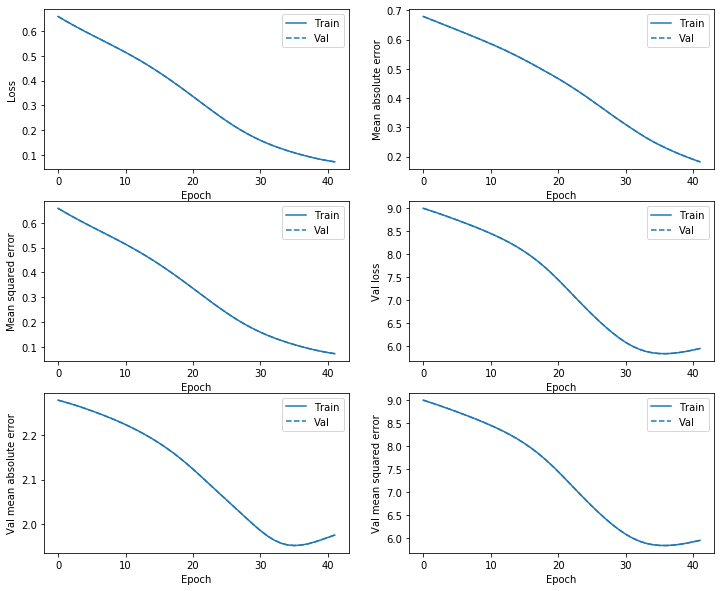

In [93]:
plot_metrics(history)

In [94]:
multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)

1/1 [==============================] - 0s 1ms/step - loss: 5.9489 - mean_absolute_error: 1.9751 - mean_squared_error: 5.9489


In [95]:
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)

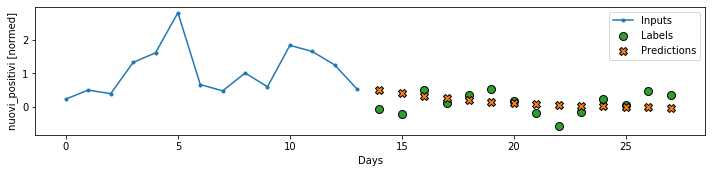

In [96]:
multi_window.plot(feedback_model, plot_col=compart)

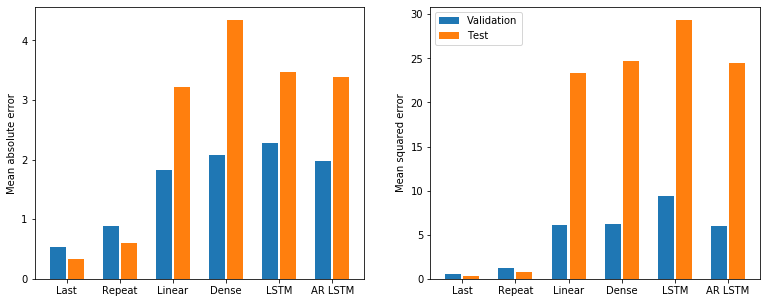

In [97]:
plot_comparison_results(multi_lstm_model.metrics_names, multi_val_performance, multi_performance, figsize=(13,5))